In [71]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import mplfinance as mpf

In [72]:
df = pd.read_csv("./02_sample_data_with_fabricated_columns.csv")

print(df.describe())

              deltaX          gamma          omega           flux  \
count  500000.000000  500000.000000  500000.000000  500000.000000   
mean       95.209593      95.402143      95.016844      95.209804   
std       103.796442     103.796594     103.797184     103.797320   
min      -211.728008    -211.323966    -211.882648    -211.767355   
25%        39.445254      39.632531      39.242162      39.438783   
50%       114.096853     114.286186     113.906685     114.114242   
75%       175.434137     175.621276     175.241753     175.425143   
max       286.705521     286.709571     286.513061     286.549948   

               pulse   neutronCount  
count  500000.000000  500000.000000  
mean       95.209737   50541.730472  
std       103.796308   28578.459770  
min      -211.500164    1000.000000  
25%        39.449301   25810.000000  
50%       114.092463   50604.000000  
75%       175.434474   75257.000000  
max       286.466974   99999.000000  


In [73]:
spearman_corr = df[[col for col in df.columns]].corr(method='spearman')
print(spearman_corr)

                deltaX     gamma     omega      flux     pulse  neutronCount
deltaX        1.000000  0.999998  0.999998  0.999994  0.999997     -0.001005
gamma         0.999998  1.000000  0.999997  0.999998  0.999998     -0.001001
omega         0.999998  0.999997  1.000000  0.999998  0.999998     -0.001005
flux          0.999994  0.999998  0.999998  1.000000  0.999997     -0.001000
pulse         0.999997  0.999998  0.999998  0.999997  1.000000     -0.001004
neutronCount -0.001005 -0.001001 -0.001005 -0.001000 -0.001004      1.000000


### Drawing Inference for Volume
Since the min value of `neutronCount` is higher than the max value of all other fields, it can be easily infered that `neutronCount` is the `volume` of the stock. Additionally, this column also has the least correlation to other columns, which in turn supports our claim.

In [74]:
df = df.rename(columns={'neutronCount': 'volume'})

In [75]:
cols_to_consider = [col for col in df.columns if col != 'volume']

high = df[cols_to_consider].idxmax(axis=1).tolist()
low = df[cols_to_consider].idxmin(axis=1).tolist()
high_count = Counter(high)
low_count = Counter(low)

print("High count:", dict(high_count))
print("Low count:", dict(low_count))

High count: {'gamma': 432559, 'pulse': 67441}
Low count: {'pulse': 67094, 'omega': 432906}


### Assumption
- **gamma**: High value  
- **omega**: Low value

In [76]:
df = df.rename(columns={'gamma': 'high'})
df = df.rename(columns={'omega': 'low'})

In [77]:
features = ['deltaX', 'pulse', 'flux']
between_high_low = pd.DataFrame({
    feature: (df['low'] <= df[feature]) & (df[feature] <= df['high'])
    for feature in features
})

between_high_low['all_between'] = between_high_low.all(axis=1)

stats = {
    feature: {
        'count_between': between_high_low[feature].sum(),
        'percent_between': between_high_low[feature].mean() * 100
    }
    for feature in features
}
stats['all_between'] = {
    'count_between': between_high_low['all_between'].sum(),
    'percent_between': between_high_low['all_between'].mean() * 100
}

print("Statistics for each feature being between high and low:")
for k, v in stats.items():
    print(f"{k}: {v['count_between']} rows ({v['percent_between']:.2f}%)")

Statistics for each feature being between high and low:
deltaX: 500000 rows (100.00%)
pulse: 365465 rows (73.09%)
flux: 500000 rows (100.00%)
all_between: 365465 rows (73.09%)


### Drawing Inference for High, Low, and Price
Based on our assumption, entirety of deltaX and flux lies between high and low. The only outlier is pulse. Thus, based on these observations and general knowledge of the stock market, we can easily claim that our initial assumptions of `High` and `Low` were correct and `Price` is represented by `flux`.

In [78]:
df = df.rename(columns={'pulse': 'price'})

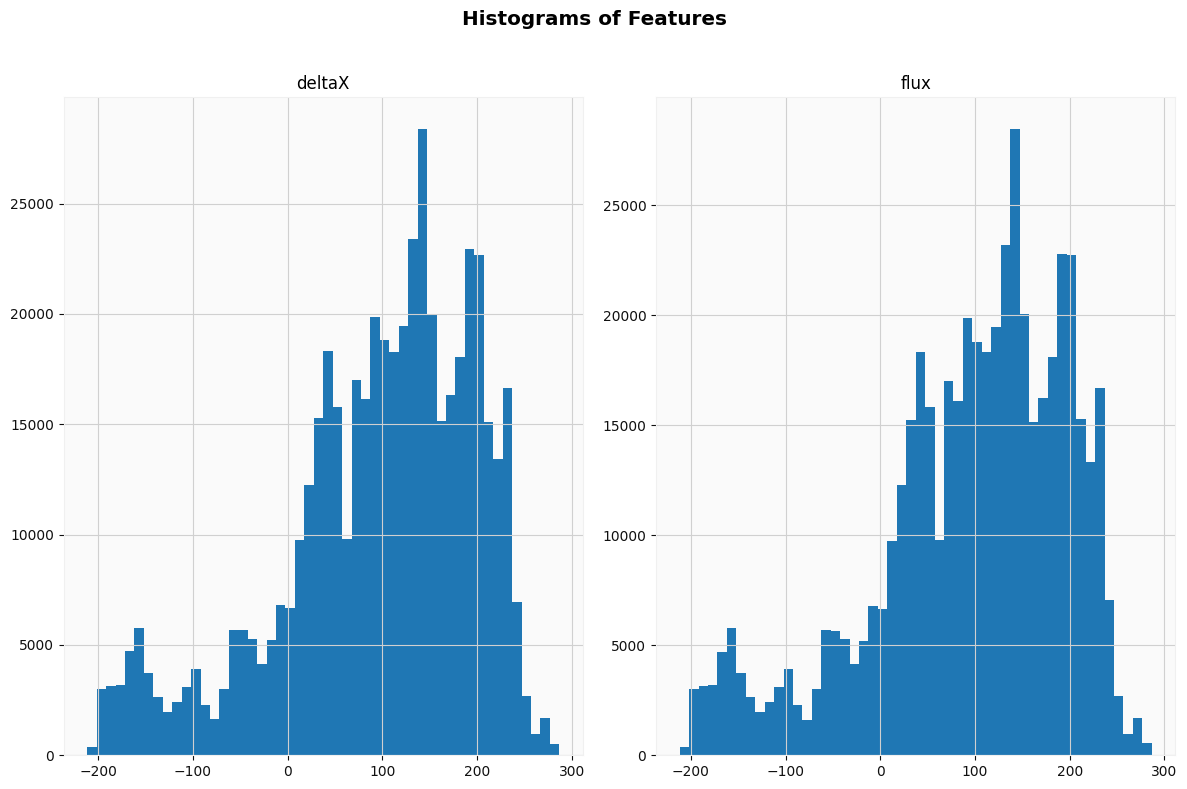

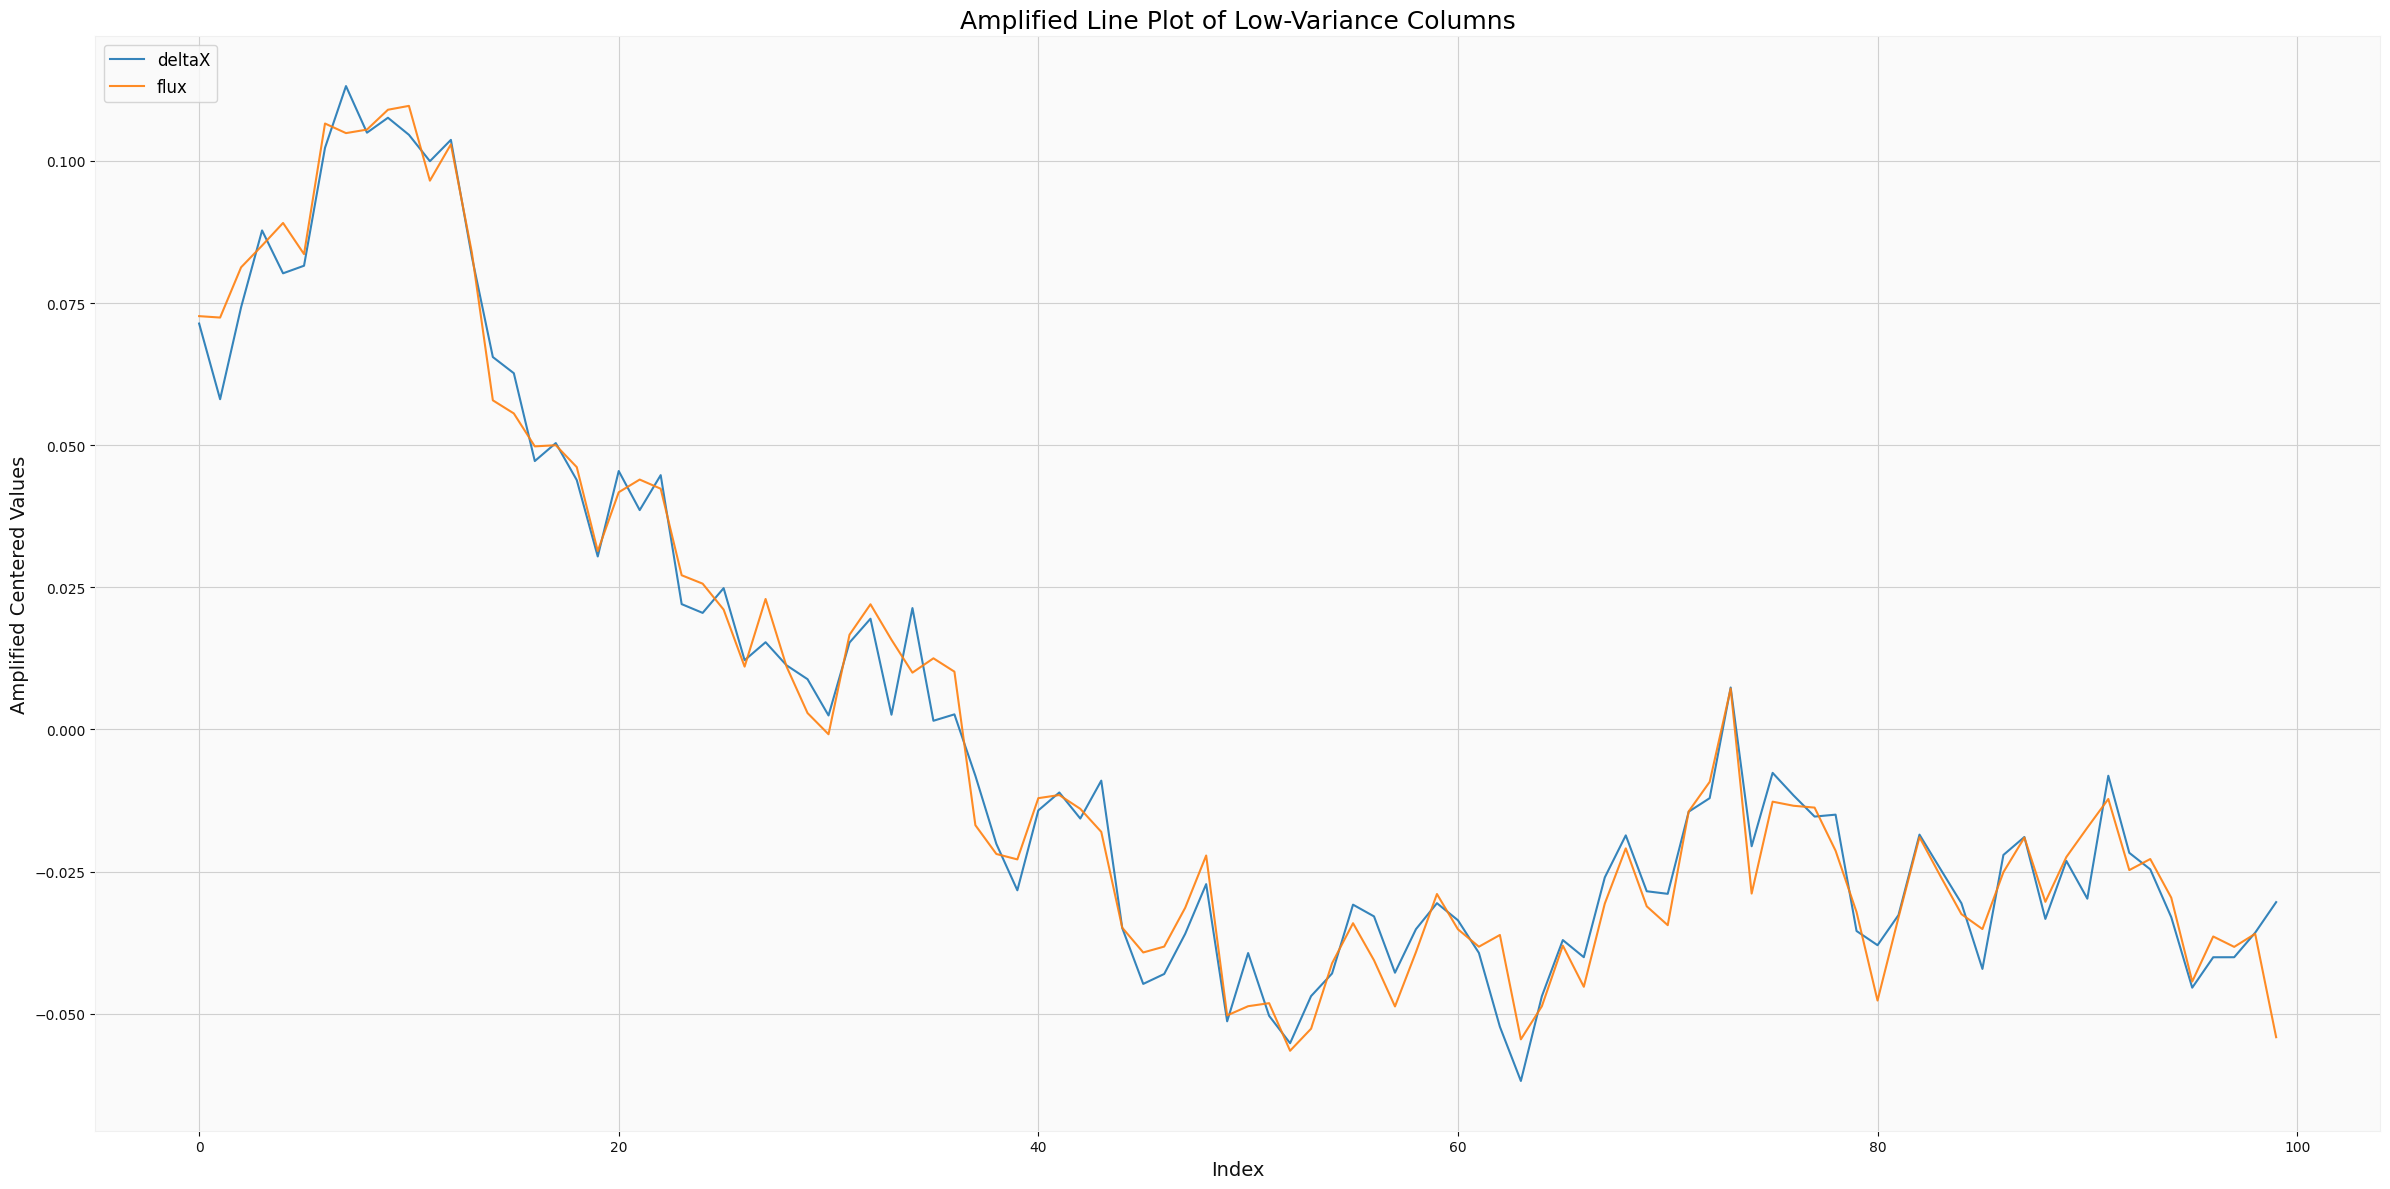

In [79]:
cols_to_consider = [col for col in df.columns if (col != 'volume' and col != 'high' and col != 'low' and col != 'price')]

df[cols_to_consider].hist(bins=50, figsize=(12, 8))
plt.suptitle('Histograms of Features')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

normalized_df = df[cols_to_consider].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
normalized_df = normalized_df[cols_to_consider].iloc[:100]
plt.figure(figsize=(24, 12))
scale_factor = 10

for i, col in enumerate(cols_to_consider):
    values = (normalized_df[col] - normalized_df[col].mean()) * scale_factor
    plt.plot(values.values, label=col, linewidth=1.5, alpha=0.9)

plt.xlabel('Index', fontsize=14)
plt.ylabel('Amplified Centered Values', fontsize=14)
plt.title('Amplified Line Plot of Low-Variance Columns', fontsize=18)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [80]:
spearman_corr = df[[col for col in df.columns if col != 'volume']].corr(method='spearman')
print(spearman_corr)

          deltaX      high       low      flux     price
deltaX  1.000000  0.999998  0.999998  0.999994  0.999997
high    0.999998  1.000000  0.999997  0.999998  0.999998
low     0.999998  0.999997  1.000000  0.999998  0.999998
flux    0.999994  0.999998  0.999998  1.000000  0.999997
price   0.999997  0.999998  0.999998  0.999997  1.000000


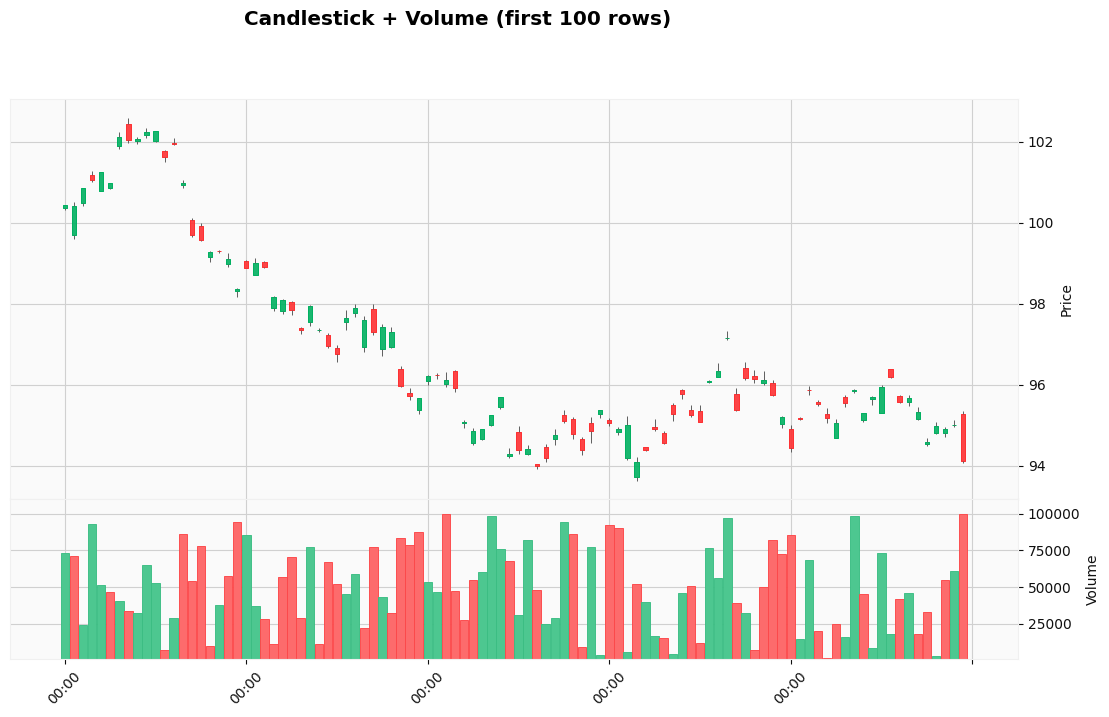

In [81]:
df_copy = df.iloc[:100].copy()

df_copy = df_copy.rename(columns={
    'deltaX':  'Open',
    'high':    'High',
    'low':     'Low',
    'flux':    'Close',
    'volume':  'Volume'
})

df_copy.index = pd.to_datetime(df_copy.index)

mpf.plot(
    df_copy,
    type='candle',      
    volume=True,        
    style='yahoo',
    figsize=(14,8),     
    title="Candlestick + Volume (first 100 rows)"
)

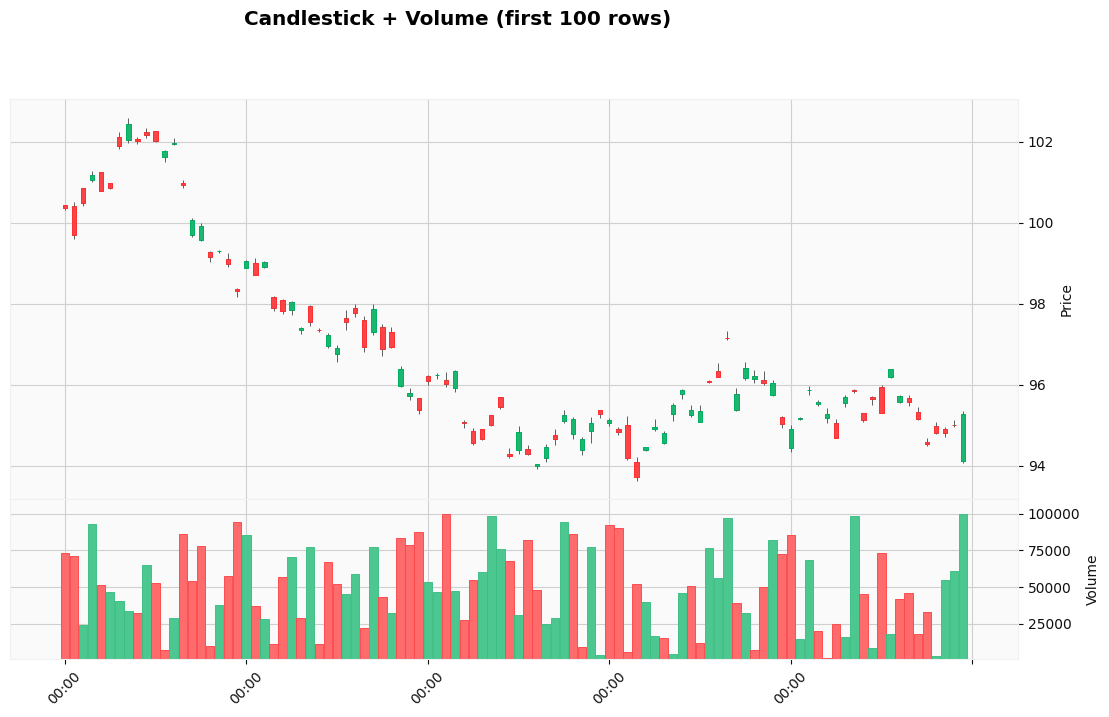

In [82]:
df_copy = df.iloc[:100].copy()

df_copy = df_copy.rename(columns={
    'flux':  'Open',
    'high':    'High',
    'low':     'Low',
    'deltaX':    'Close',
    'volume':  'Volume'
})

df_copy.index = pd.to_datetime(df_copy.index)

mpf.plot(
    df_copy,
    type='candle',
    volume=True,  
    style='yahoo',
    figsize=(14,8),
    title="Candlestick + Volume (first 100 rows)"
)

In [83]:
candidates = ['deltaX', 'flux']

Heuristic 1: Close is expected average of high, low, price (typically the candle midpoint)

In [84]:
def expected_close(df):
    expected_close = (df['high'] + df['low'] + df['price']) / 3
    return expected_close

Heuristic 2: Close has a stronger correlation with next price (that is close tends to predict next price better)

In [85]:
def close_nextPrice_corr(df,col):
    corr_nextPrice=df[col].corr(df['price'].shift(-1))
    return corr_nextPrice

Heuristic 3: Both open and close show some drift over time

In [86]:
def close_time_corr(df,col):
    corr_time=df[col].corr(pd.Series(df.index))
    return corr_time

### Combining all obtained correlations to predict close/open price with confidence score

In [87]:
expected_close=expected_close(df)

results = {}
for col in candidates:
    other_col = [c for c in candidates if c != col][0]

    difference_close_expectedClose=abs(df[col] - expected_close).mean() # Check-1
    correlation_close_nextPrice=close_nextPrice_corr(df,col)
    correlation_close_time=close_time_corr(df,col)
    
    results[col] = {
        'diff_expected_close': abs(df[col] - expected_close).mean(),
        'correlation_next_price': correlation_close_nextPrice,
        'time_correlation': correlation_close_time,
    }

scores_df = pd.DataFrame(results).T

scores_df['inv_diff_expected_close'] = 1 / scores_df['diff_expected_close']  # Invert difference as lower is better

metrics_df=scores_df[[
    'inv_diff_expected_close',
    'correlation_next_price', 'time_correlation'
]]

weights = {
    'inv_diff_expected_close': 0.4,
    'correlation_next_price': 0.5,
    'time_correlation': 0.1,
}

final_score = (metrics_df* pd.Series(weights)).sum(axis=1)
scores_df['close_weighted_score'] = final_score

print("Weighted scores for each of the candidate columns to be 'CLOSE'\n")
print(scores_df[['close_weighted_score']].sort_values(by='close_weighted_score', ascending=False))

Weighted scores for each of the candidate columns to be 'CLOSE'

        close_weighted_score
deltaX               3.73942
flux                 3.73874


### Drawing Inference for Open and Close
As seen we can from the histograms, lineplots, candlestick plots, and the manual heuristics introduced by us (based on popular observations in the stock market), we can safely conclude that deltaX and flux are both equally probable to be Open and Close. Thus, we will assign a random columm among these two, to them with 0.5 as confidence to each.

Note: Although the lineplots and candlestick plots only show first few instances for readability, we did plot them over randomly selected ranges, and observed the same pattern. We could not include the same owing to space constraints.